In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet_graphs_train import generate_paper_experiments

In [3]:
experiments = generate_paper_experiments()

In [4]:
global_save_path = os.path.join("datasets", "paper_experiments")
predictions_save_path = os.path.join(global_save_path, "results")
plots_path = os.path.join(global_save_path, "plots")

In [5]:
def get_prediction_column(prefix, target):
  return f"{prefix}predicted_{target}"

In [6]:
# Assumes all experiments are on the same data and use the fold defenitions!
data = pd.read_pickle(experiments[0].data_path)
folds = pd.read_csv(experiments[0].folds_path, squeeze=True, index_col="_id")

def process_experiment(experiment):
  assert experiment.data_path == experiments[0].data_path
  assert experiment.folds_path == experiments[0].folds_path  
  model = MEGNetModel.from_file(os.path.join(experiment.model_path))
  return model.predict_structures(data.defect_representation)

In [7]:
from multiprocessing import Pool
with Pool(20) as p:
  predictions = p.map(process_experiment, experiments)

In [8]:
maes = []
test_prediction_column = f"test_predicted_{experiments[0].target}"
columns_to_save = [test_prediction_column]
for experiment, this_predictions in zip(experiments, predictions):  
  predictions_pd = pd.Series(data=this_predictions.ravel(), index=data.index)
  train_prediction_column = f"train_fold_-{experiment.test_fold}_predicted_{experiment.target}"
  columns_to_save.append(train_prediction_column)
  
  test_ids = folds[folds == experiment.test_fold].index
  train_ids = folds[folds != experiment.test_fold].index
  
  data.loc[test_ids, test_prediction_column] = predictions_pd.loc[test_ids]
  data.loc[train_ids, train_prediction_column] = predictions_pd.loc[train_ids]
  maes.append(np.mean(np.abs(
    predictions_pd.loc[test_ids] - data.loc[test_ids, experiment.target])))

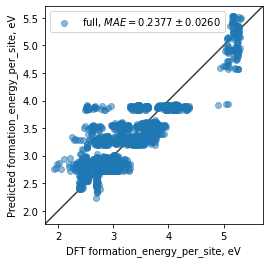

In [9]:
experiment = experiments[0]
data_name = "full"
fig, ax = plt.subplots()
mae = np.mean(maes)
mae_std = np.std(maes)
ax.scatter(data.loc[:, experiment.target], data.loc[:, test_prediction_column],
           label=f"{data_name}, $MAE={mae:.4f} \pm {mae_std:.4f}$",
           alpha=0.5)
  
ax.set_xlabel(f"DFT {experiment.target}, eV")
ax.set_ylabel(f"Predicted {experiment.target}, eV")
ax.legend()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
  ]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
fig.savefig(os.path.join(plots_path, f"{experiment.target}_{experiment.name}.pdf"),
            bbox_inches="tight",
            metadata={
              "Author": "Nikita Kazeev",
              "Title": f"MEGNet on defect-only representation, {experiment.target}, {experiment.name}",
              "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
           )

In [10]:
data.to_csv(os.path.join(predictions_save_path, "full.csv.gz"),
            columns=columns_to_save, index_label="_id")